# Setup

In [207]:
import matplotlib.pyplot as plt
import torch.nn as nn
import numpy as np
import torchvision
import pathlib
import torch

from util import dataloaders
from util.trainer import Trainer
from util import utils

In [208]:
input_dir = pathlib.Path("images/input")
output_dir = pathlib.Path("images/output")
data_dir = pathlib.Path("data")
output_dir.mkdir(exist_ok=True)
data_dir.mkdir(exist_ok=True)

# Task 4a

Use the given starter code and train a single-layer neural network with batch size of 64.
Then, normalize every image between a range of [-1. 1], and train the network again.
Plot the training and validation loss from both of the networks in the same graph. Include the graph in your report. Do you notice any difference when training your network with/without normalization?

Tip: You can normalize the image to the range of [-1, 1] by using an image transform. Use torchvision.transforms.Normalize with mean = 0.5, and std = 0.5, and include it after trans- forms.ToTensor().
From this task, use normalization for every subsequent task.

In [209]:
batch_size = 64
learning_rate = .0192
num_epochs = 5
loss_function = torch.nn.CrossEntropyLoss() # for multi-class classification

def create_model():
    model = nn.Sequential(
        nn.Flatten(),
        nn.Linear(28 * 28 * 1, 10)
    )
    model = utils.to_cuda(model)
    return model

## Training Single-Layer Neural Network

Loading the Data

In [210]:
torch.random.manual_seed(0)
np.random.seed(0)

image_transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])

dataloader_train, dataloader_test = dataloaders.load_dataset(batch_size, image_transform)
example_images, _ = next(iter(dataloader_train))
print(f"The tensor containing the images has shape: ([batch size, number of color channels, height, width])={example_images.shape}")
print(f"The maximum value in the image is {example_images.max()}, minimum: {example_images.min()}", sep="\n\t")
example_images = utils.to_cuda(example_images)

The tensor containing the images has shape: ([batch size, number of color channels, height, width])=torch.Size([64, 1, 28, 28])
The maximum value in the image is 1.0, minimum: 0.0


Creating the model

In [211]:
model = create_model()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate) # Stochastic Gradient Descent
output = model(example_images)
expected_shape = (batch_size, 10) # 10 since MNIST has 10 different classes
assert output.shape == expected_shape, f"Expected shape: {expected_shape}, but got: {output.shape}"

### Train model

In [212]:
trainer = Trainer(
  model=model,
  dataloader_train=dataloader_train,
  dataloader_test=dataloader_test,
  batch_size=batch_size,
  loss_function=loss_function,
  optimizer=optimizer
)
taskA_train_loss_dict, taskA_test_loss_dict = trainer.train(num_epochs)

loss, accuracy = utils.compute_loss_and_accuracy(dataloader_test, model, loss_function)
print(f"Loss: \t\t{loss:.2f}\nAccuracy: \t{accuracy:.2f}")

Training epoch 4: 100%|██████████| 938/938 [00:04<00:00, 197.07it/s]


Loss: 		0.34
Accuracy: 	0.91


## Training Single-Layer Neural Network With Normalization

### Reset and Reload with Normalization

In [213]:
torch.random.manual_seed(0)
np.random.seed(0)

# Add Normalization
image_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(0.5, 0.5),
])

dataloader_train, dataloader_test = dataloaders.load_dataset(batch_size, image_transform)
example_images, _ = next(iter(dataloader_train))
print(f"The tensor containing the images has shape: ([batch size, number of color channels, height, width])={example_images.shape}")
print(f"The maximum value in the image is {example_images.max()}, minimum: {example_images.min()}", sep="\n\t")
example_images = utils.to_cuda(example_images)

The tensor containing the images has shape: ([batch size, number of color channels, height, width])=torch.Size([64, 1, 28, 28])
The maximum value in the image is 1.0, minimum: -1.0


### Recreate Model

In [214]:
model = create_model()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate) # Stochastic Gradient Descent

### Train the model

In [215]:
trainer = Trainer(
  model=model,
  dataloader_train=dataloader_train,
  dataloader_test=dataloader_test,
  batch_size=batch_size,
  loss_function=loss_function,
  optimizer=optimizer
)
taskA_normalized_train_loss_dict, taskA_normalized_test_loss_dict = trainer.train(num_epochs)

norm_loss, norm_accuracy = utils.compute_loss_and_accuracy(dataloader_test, model, loss_function)
print(f"Loss: \t\t{norm_loss:.2f}\nAccuracy: \t{norm_accuracy:.2f}")

Training epoch 4: 100%|██████████| 938/938 [00:07<00:00, 123.74it/s]


Loss: 		0.29
Accuracy: 	0.91


## Plot and Compare With and Without Normalization

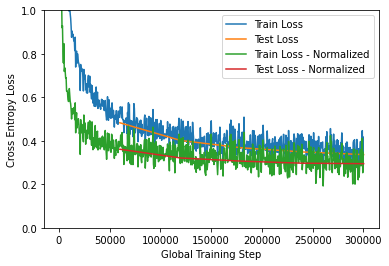

Difference in Loss: 		-0.0416
Difference in Accuracy: 	0.0044


In [216]:
utils.plot_loss(taskA_train_loss_dict, label="Train Loss")
utils.plot_loss(taskA_test_loss_dict, label="Test Loss")
utils.plot_loss(taskA_normalized_train_loss_dict, label="Train Loss - Normalized")
utils.plot_loss(taskA_normalized_test_loss_dict, label="Test Loss - Normalized")
plt.ylim([0, 1])
plt.legend()
plt.xlabel("Global Training Step")
plt.ylabel("Cross Entropy Loss")
plt.savefig(output_dir.joinpath("task-4a.png"))
plt.show()

print(f"Difference in Loss: \t\t{norm_loss - loss:.4f}\nDifference in Accuracy: \t{norm_accuracy - accuracy:.4f}")

# Task 4b

The trained neural network will have one weight with shape [num classes, 28 × 28]. To visualize the learned weight, we can plot the weight as a 28 × 28 grayscale image.
For each digit (0-9), plot the learned weight as a 28 × 28 image. In your report, include the image for each weight, and describe what you observe (1-2 sentences).

Tip: You can access the weight of the fully connected layer by using the following snippet: weight = list(model.children())[1].weight.cpu().data

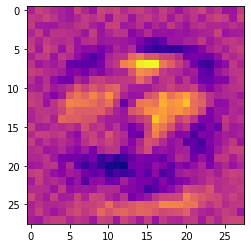

In [217]:
weight = list(model.children())[1].weight.cpu().data

for i in range(10):
    plt.imshow(torch.reshape(weight[i], (28, 28)), cmap='plasma')
    plt.savefig(output_dir.joinpath(f'task-4b-{str(i)}.png'))

# Task 4c

Set the learning rate to lr = 1.0, and train the network from scratch.
Report the accuracy and average cross entropy loss on the validation set. In 1-2 sentences, explain
why the network achieves worse/better accuracy than previously.

Tip: To observe what is happening to the loss, you should change the plt.ylim argument.

In [218]:
learning_rate = 1.0

### Reset and Reload

In [219]:
torch.random.manual_seed(0)
np.random.seed(0)

dataloader_train, dataloader_test = dataloaders.load_dataset(batch_size, image_transform)
example_images, _ = next(iter(dataloader_train))
example_images = utils.to_cuda(example_images)

### Create new model and optimizer with new learning rate

In [220]:
model = create_model()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

### Train the model

In [221]:
trainer = Trainer(
  model=model,
  dataloader_train=dataloader_train,
  dataloader_test=dataloader_test,
  batch_size=batch_size,
  loss_function=loss_function,
  optimizer=optimizer
)
taskC_train_loss_dict, taskC_test_loss_dict = trainer.train(num_epochs)

loss, accuracy = utils.compute_loss_and_accuracy(dataloader_test, model, loss_function)
print(f"Loss: \t\t{loss:.2f}\nAccuracy: \t{accuracy:.2f}")

Training epoch 4: 100%|██████████| 938/938 [00:09<00:00, 102.44it/s]


Loss: 		2.21
Accuracy: 	0.89


### Plot Results

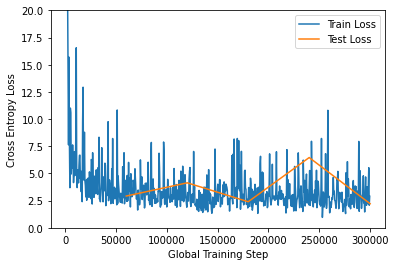

In [222]:
utils.plot_loss(taskC_train_loss_dict, label="Train Loss")
utils.plot_loss(taskC_test_loss_dict, label="Test Loss")
plt.ylim([0, 20])
plt.legend()
plt.xlabel("Global Training Step")
plt.ylabel("Cross Entropy Loss")
plt.savefig(output_dir.joinpath('task-4c.png'))
plt.show()

# Task 4d

Include an hidden layer with 64 nodes in the network, with ReLU as the activation function for the first layer. Train this network with the same hyperparameters as previously.

Plot the training and validation loss from this network together with the loss from task (a). Include the plot in your report. What do you observe?

In [223]:
learning_rate = .0192

def create_model_with_hidden_layer():
    model = nn.Sequential(
        nn.Flatten(), 
        nn.Linear(28 * 28 * 1, 64),
        nn.ReLU(),
        nn.Linear(64, 10)
    )
    model = utils.to_cuda(model)
    return model

### Reset and Relaod

In [224]:
torch.random.manual_seed(0)
np.random.seed(0)

dataloader_train, dataloader_test = dataloaders.load_dataset(batch_size, image_transform)
example_images, _ = next(iter(dataloader_train))
example_images = utils.to_cuda(example_images)

### Create new Model and Optimizer

In [225]:
model = create_model_with_hidden_layer()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

### Train

In [226]:
trainer = Trainer(
  model=model,
  dataloader_train=dataloader_train,
  dataloader_test=dataloader_test,
  batch_size=batch_size,
  loss_function=loss_function,
  optimizer=optimizer
)
taskD_train_loss_dict, taskD_test_loss_dict = trainer.train(num_epochs)

loss, accuracy = utils.compute_loss_and_accuracy(dataloader_test, model, loss_function)
print(f"Loss: \t\t{loss:.2f}\nAccuracy: \t{accuracy:.2f}")

Training epoch 4: 100%|██████████| 938/938 [00:07<00:00, 120.39it/s]


Loss: 		0.21
Accuracy: 	0.94


### Plot And Calculate Difference From Task A

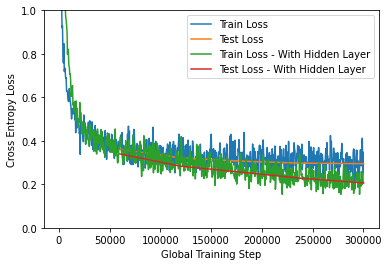

Difference in Loss: 		-0.0885
Difference in Accuracy: 	0.0268


In [227]:
utils.plot_loss(taskA_normalized_train_loss_dict, label="Train Loss")
utils.plot_loss(taskA_normalized_test_loss_dict, label="Test Loss")
utils.plot_loss(taskD_train_loss_dict, label="Train Loss - With Hidden Layer")
utils.plot_loss(taskD_test_loss_dict, label="Test Loss - With Hidden Layer")
plt.ylim([0, 1])
plt.legend()
plt.xlabel("Global Training Step")
plt.ylabel("Cross Entropy Loss")
plt.savefig(output_dir.joinpath('task-4d.png'))
plt.show()

print(f"Difference in Loss: \t\t{loss - norm_loss:.4f}\nDifference in Accuracy: \t{accuracy - norm_accuracy:.4f}")